# onnxruntime-training, scikit-learn

Simple examples mixing packages. The notebook takes a neural network from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) (regression), converts it into [ONNX](https://onnx.ai/) and trains it with [onnxruntime-training](https://github.com/microsoft/onnxruntime-training-examples).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

In [3]:
%load_ext mlprodict

In [4]:
import warnings
from time import perf_counter
warnings.filterwarnings("ignore")

## Data and first model

In [5]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

data = load_diabetes()
X, y = data.data, data.target
y /= 100
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(hidden_layer_sizes=(20,), max_iter=400)
begin = perf_counter()
nn.fit(X_train, y_train)
print("training time: %r" % (perf_counter() - begin))

training time: 0.9272374000000028


In [7]:
from sklearn.metrics import r2_score
r2_score(y_test, nn.predict(X_test))

0.4844054606180469

## Conversion to ONNX

With [skl2onnx](https://github.com/onnx/sklearn-onnx).

In [8]:
import numpy
from skl2onnx import to_onnx

nn = MLPRegressor(hidden_layer_sizes=(20,), max_iter=1).fit(X_train, y_train)
nn_onnx = to_onnx(nn, X_train[1:].astype(numpy.float32))

%onnxview nn_onnx

## Training with pytorch + ONNX

We could use onnxruntime-training only (see [Train a linear regression with onnxruntime-training](http://www.xavierdupre.fr/app/onnxcustom/helpsphinx/gyexamples/plot_orttraining_linear_regression.html) but instead we try to extend [pytorch](https://pytorch.org/) with a custom function defined with an ONNX graph, the one obtained by converting a neural network from scikit-learn into ONNX. First, let's get the list of parameters of the model.

In [9]:
from onnx.numpy_helper import to_array

weights = [(init.name, to_array(init)) 
           for init in nn_onnx.graph.initializer
           if 'shape' not in init.name]
[w[0] for w in weights]

['coefficient', 'intercepts', 'coefficient1', 'intercepts1']

Class [TorchOrtFactory](http://www.xavierdupre.fr/app/deeponnxcustom/helpsphinx/deeponnxcustom/onnxtorch/torchort.html#deeponnxcustom.onnxtorch.torchort.TorchOrtFactory) creates a torch function by taking the ONNX graph and the weights to learn.

In [10]:
from deeponnxcustom.onnxtorch import TorchOrtFactory

try:
    fact = TorchOrtFactory(nn_onnx, [w[0] for w in weights])
except ValueError as e:
    print(e)

No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.4'
List of weights to train must be sorted but is not in ['coefficient', 'intercepts', 'coefficient1', 'intercepts1']. You shoud use function onnx_rename_weights to do that before calling this class.


The function fails because the weights needs to be in alphabetical order. We use a function to rename them.

In [11]:
from deeponnxcustom.tools.onnx_helper import onnx_rename_weights

onnx_rename_weights(nn_onnx)
weights = [(init.name, to_array(init)) 
           for init in nn_onnx.graph.initializer
           if 'shape' not in init.name]
[w[0] for w in weights]

['I0_coefficient', 'I1_intercepts', 'I2_coefficient1', 'I3_intercepts1']

We start again.

In [12]:
fact = TorchOrtFactory(nn_onnx, [w[0] for w in weights])

Let's create the torch function.

In [13]:
cls = fact.create_class()
cls

deeponnxcustom.onnxtorch.torchort.TorchOrtFunction_2140275442256

In [14]:
cls.__bases__

(deeponnxcustom.onnxtorch.torchort.TorchOrtFunction,)

In [15]:
cls.__bases__[0].__bases__

(torch.autograd.function.Function,)

Let's train it.

In [16]:
from tqdm import tqdm
import torch


def from_numpy(v, device=None, requires_grad=False):
    v = torch.from_numpy(v)
    if device is not None:
        v = v.to(device)
    v.requires_grad_(requires_grad)
    return v


def train_cls(cls, device, X_train, y_train, weights, n_iter=20, learning_rate=1e-3):
    x = from_numpy(X_train.astype(numpy.float32), 
                   requires_grad=True, device=device)
    y = from_numpy(y_train.astype(numpy.float32),
                   requires_grad=True, device=device)
    fact = torch.tensor([x.shape[0]], dtype=torch.float32).to(device)
    fact.requires_grad_(True)

    weights_tch = [(w[0], from_numpy(w[1], requires_grad=True, device=device))
                   for w in weights]
    weights_values = [w[1] for w in weights_tch]

    all_losses = []
    for t in tqdm(range(n_iter)):
        # forward - backward
        y_pred = cls.apply(x, *weights_values)
        loss = (y_pred - y).pow(2).sum() / fact
        loss.backward()

        # update weights
        with torch.no_grad():
            for w in weights_values:
                w -= w.grad * learning_rate
                w.grad.zero_()

        all_losses.append((t, float(loss.detach().numpy())))
    return all_losses, weights_tch


device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
print("device:", device)

begin = perf_counter()
train_losses, final_weights = train_cls(cls, device, X_train, y_test, weights, n_iter=400)
print("training time: %r" % (perf_counter() - begin))

device: cpu


100%|██████████| 400/400 [00:00<00:00, 428.75it/s]


training time: 0.9546589000000054


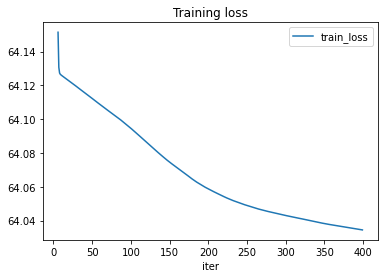

In [17]:
from pandas import DataFrame

df = DataFrame(data=train_losses, columns=['iter', 'train_loss'])
df[6:].plot(x="iter", y="train_loss", title="Training loss");